# Prioritized Experience Replay (PER)
In PER, for training, we *prioritize* selecting transitions with high TD (Temporal Difference) error, which can be comparable to the "unexpectedness" of a state following some action.
This alone adds some bias during the training, because we'll be updating the model more often based on a more select set of transitions, introducing a form of overfitting. 

To compensate for this, we decrease the effect of those high selectance samples with *weights* on the moment that the loss is backpropagated.

In a nutshell, we select more of a few samples, and to not "pull" the model too much into fitting mostly these (that is, overfitting), we introduce weights.

Also, the implementation of our Prioritized Replay Buffer is rank-based; that is, high priority entries are selected first (and possibly more than once), and then we move on to entries of lesser priority. 

- Good resource: https://danieltakeshi.github.io/2019/07/14/per/
- Paper: https://arxiv.org/abs/1511.05952v4

## Setup

In [37]:
NB_ID = '03+02'

import gymnasium as gym
from gymnasium.wrappers.record_video import RecordVideo

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import random
import matplotlib.pyplot as plt

from IPython.display import clear_output

from typing import Dict, List, Tuple

from segment_tree import MinSegmentTree, SumSegmentTree

plt.ion()

## Replay buffer

In [38]:
class ReplayBuffer:
    def __init__(self, obs_rank: int, max_size: int, batch_size:int=32):
        self.state_buf = np.zeros((max_size, obs_rank), dtype=np.float32)
        self.action_buf = np.zeros(max_size, dtype=np.float32)
        self.reward_buf = np.zeros(max_size, dtype=np.float32)
        self.ns_buf = np.zeros((max_size, obs_rank), dtype=np.float32)
        self.done_buf = np.zeros(max_size, dtype=np.float32)

        self.max_size, self.batch_size = max_size, batch_size
        self.ptr, self.size = 0, 0

    def push(self, 
        state: np.ndarray, 
        action: int, 
        reward: float, 
        ns: np.ndarray, 
        done: bool,
    ):
        idx = self.ptr
        self.state_buf[idx] = state
        self.action_buf[idx] = action
        self.reward_buf[idx] = reward
        self.ns_buf[idx] = ns
        self.done_buf[idx] = done
        
        self.ptr = (idx + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
    
    def sample(self) -> Dict[str, np.ndarray]:
        idx = random.sample(range(self.size), self.batch_size)
        return dict(
            state=self.state_buf[idx],
            action=self.action_buf[idx],
            reward=self.reward_buf[idx],
            ns=self.ns_buf[idx],
            done=self.done_buf[idx],
        )

    def __len__(self):
        return self.size

## Prioritized replay buffer

In [39]:
class PrioritizedReplayBuffer(ReplayBuffer):
    def __init__(
        self,
        obs_rank: int,
        max_size: int,
        batch_size: int = 32,
        alpha: float = 0.6
    ):
        assert alpha >= 0

        super().__init__(obs_rank, max_size, batch_size)
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha

        tree_capacity = 1
        # tree_capacity will end up larger than max_size
        while tree_capacity < self.max_size:
            tree_capacity *= 2
        self.tree_capacity = tree_capacity

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
    
    def push(
        self,
        obs: np.ndarray,
        act: int,
        rew: float,
        next_obs: np.ndarray,
        done: bool
    ):
        super().push(obs, act, rew, next_obs, done)

        # we are gonna "interlace" the two to calculate the TD error
        self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
        # NOTE: I thought min_tree was a weird way to operate, but it only makes
        # sense because you want bias corrections to occur across the whole training,
        # not just one batch.
        self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
        self.tree_ptr = (self.tree_ptr + 1) % self.max_size

    def sample(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        assert len(self) >= self.batch_size
        assert beta > 0

        # indices (plural)
        idx = self._sample_proportional()

        return dict(
            state=self.state_buf[idx],
            action=self.action_buf[idx],
            reward=self.reward_buf[idx],
            ns=self.ns_buf[idx],
            done=self.done_buf[idx],
            weight=np.array([self._calculate_weight(i, beta) for i in idx]),
            idx=idx,
        )

    def _sample_proportional(self) -> List[int]:
        # we do all of this even though we could use the random package's 
        # weighted samples method, because we need to be EFFICIENT in computation.
        indices = []
        # we insert end here because the size of our 
        # memory will be smaller than the tree
        # NOTE: I think it wold be fine if we ommitted these parameters,
        # if we initialize the tree with values 0
        p_total = self.sum_tree.sum(start=0, end=len(self) - 1)
        # divide total td sum over each batch
        segment = p_total / self.batch_size

        # the idea here is that the range a to b will cover ALL samples
        # one iteration at a time, that is, one segment at a time
        print('doing 1 batch')
        print('segm', segment)
        print('our tree lookin like', self.sum_tree._value[self.tree_capacity:])
        print()
        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            # because we ranked higher values first, we will retrieve
            # the 1st sample a couple times, 2nd sample a couple times less, and so on
            # basically, a Power law distribution
            idx = self.sum_tree.find_prefixsum_idx(upperbound)
            indices.append(idx)
            print('indices', idx, a, b, i, upperbound)

        return indices

    def _calculate_weight(self, idx: int, beta:float):
        # get lowest probability, hence the max weight
        # check paper for details
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)

        p_idx = self.min_tree[idx] / self.sum_tree.sum()
        weight = (p_idx * len(self)) ** (-beta)
        weight = weight / max_weight
        return weight

    def update_priorities(self, indices: List[int], priorities:np.ndarray):
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            # will be used for $P(i)=\frac{p(i)^\alpha}{\sum_k{p(k)^\alpha}}$
            # I don't think there'd be any other way to implement this other than when we store it
            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)


        

## Network

In [40]:
class Network(nn.Module):
    def __init__(
        self,
        in_size,
        out_size
    ):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_size)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

## DQN agent

In [41]:
class DQNAgent:
    def __init__(self,
        env: gym.Env,
        seed: int,
        memory_size: int,
        batch_size: int,
        target_update: int,
        eps_decay: float,
        max_eps: float = .9,
        min_eps: float = .1,
        gamma: float = .99,
        # PER parameters
        # selection bias (less is more)
        # NOTE: alpha doe snot get updated
        alpha: float = 0.2,
        # weight factor
        beta: float = 0.6,
        prior_eps: float = 1e-6,
    ):
        self.env = env
        self.seed = seed
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.target_update = target_update
        self.eps_decay = eps_decay
        self.eps = max_eps
        self.max_eps = max_eps
        self.min_eps = min_eps
        self.gamma = gamma

        self.beta = beta
        self.prior_eps = prior_eps

        obs_size = env.observation_space.shape[0]
        action_size = env.action_space.n

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        
        self.memory = PrioritizedReplayBuffer(obs_size, memory_size, batch_size, alpha)
        
        self.dqn = Network(obs_size, action_size).to(self.device)
        self.dqn_target = Network(obs_size, action_size).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        self.optimizer = optim.AdamW(self.dqn.parameters(), amsgrad=True)

        self.transition = []

        self.is_test = False

    def choose_action(self, state: np.ndarray) -> int:
        explore = self.eps > np.random.random()
        if explore:
            selected_action = self.env.action_space.sample()
        if not explore or self.is_test:
            selected_action = self.dqn(torch.FloatTensor(state)).argmax().item()
        if not self.is_test:
            self.transition = [state, selected_action]
        return selected_action
    
    def take_step(self, action: int) -> Tuple[np.ndarray, np.float64, bool]:
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        
        done = terminated or truncated
        
        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.push(*self.transition)
            
        return next_state, reward, done
    
    def compute_dqn(self, samples: dict[str, np.array]):
        """calculate the DQN loss for a batch of memories"""
        device = self.device
        # each of these is a batch/samples of their corresponding name
        state = torch.FloatTensor(samples["state"], device=device)
        ns = torch.FloatTensor(samples["ns"], device=device)
        action = torch.LongTensor(samples["action"], device=device)
        reward = torch.FloatTensor(samples["reward"], device=device)
        done = torch.FloatTensor(samples["done"], device=device)

        # we need to unsqueeze actions because gather requires the 2 tensors to be of same shape,
        # even if the relevant idx's dimension has size 1.
        # and then we squeeze so that:
        # [[q1], [q2], [qn]] -> [q1, q2, qn]
        # ^ the output is like this because tensorflow retains the shape
        curr_q_value = self.dqn(state).gather(1, action.unsqueeze(1)).squeeze()
        with torch.no_grad():
            # get q-values tensor for action space
            # these 2 are equivalent
            # next_actions = self.dqn(ns).argmax(1).unsqueeze(1)
            next_actions = self.dqn(ns).argmax(1, keepdim=True)
            next_q_values = self.dqn_target(ns)
            next_q_value = next_q_values.gather(1, next_actions).squeeze()
        mask = 1 - done
        target = (reward + next_q_value * self.gamma * mask).to(self.device)
        elementwise_loss = F.smooth_l1_loss(curr_q_value, target, reduction='none')
        
        # # for debugging!
        # print('state', state[:2])
        # print('ns', ns[:2])
        # print('act', action[:2])
        # print('rew', reward[:2])
        # print('done', done[:2])
        # print('curr_q', curr_q_value[:2])
        # print('curr_q_sqz', curr_q_value.squeeze(0)[:2])
        # print('next_act', next_actions[:2])
        # print('next_qs', next_q_values[:2])
        # print('next_q', next_q_value[:2])
        # print('target', target[:2])

        mean_q_value = torch.mean(curr_q_value).detach().numpy()
        return elementwise_loss, mean_q_value
        
    def update_model(self) -> float:
        samples = self.memory.sample(self.beta)
        weights = torch.FloatTensor(samples['weight'], device=self.device).unsqueeze(0)
        indices = samples['idx']

        elementwise_loss, q_value = self.compute_dqn(samples)
        loss = torch.mean(elementwise_loss * weights)

        # if in doubt, check comments on cartpole dqn
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # NOTE: we use the new priorities from BEFORE the model gets updated (backprop).
        # it seems to me that it would make more sense to feed back the weights
        # from AFTER the update, but then we'd have to calculate the Q-values twice.

        # turn into numpy array
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        # because we use alpha, these will decay over time
        self.memory.update_priorities(indices, new_priorities)

        return loss.item(), q_value

    def train(self, seed: int, num_frames: int, plotting_interval: int=200):
        try:
            self.is_test = False

            state, _ = self.env.reset(seed=seed)
            # effective episode - n. of episodes after initial "memory gathering"
            total_episodes = 0
            eff_episode = 0
            score = 0
            scores = []
            losses = []
            epsilons = []
            predictions = []
            
            for frame_idx in range(1, num_frames+1):
                action = self.choose_action(state)
                next_state, reward, done = self.take_step(action)

                state = next_state
                score += reward

                fraction = min(frame_idx / num_frames, 1)
                # NOTE: this has a log curve
                self.beta = self.beta + (1 - self.beta) * fraction

                if done:
                    total_episodes += 1
                    state, _ = self.env.reset(seed=seed+total_episodes)
                    scores.append(score)
                    score = 0
                if len(self.memory) >= self.batch_size:
                    loss, curr_q_value = self.update_model()
                    losses.append(loss)
                    predictions.append(curr_q_value)
                    eff_episode += 1
                    # linear decay
                    self.eps = max(self.min_eps, self.eps - (self.max_eps - self.min_eps) * self.eps_decay)
                    epsilons.append(self.eps)

                    if eff_episode % self.target_update == 0:
                        self.target_hard_update()

                if frame_idx % plotting_interval == 0:
                    self._plot(frame_idx, scores, losses, epsilons, predictions)
        except KeyboardInterrupt:
            self.save_state()
        else:
            self.save_state('saved-state-done')
        self.env.close()
    
    def save_state(self, name='saved-state'):
        state_dict = self.dqn.state_dict()
        torch.save(state_dict, f'saved-states/{NB_ID}.s{self.seed}.pt')
        print('saved state!')
        return state_dict

    def load_state(self, state_dict):
        self.dqn.load_state_dict(state_dict)
        return state_dict
        
    def test(self, video_folder: str):
        self.is_test = True
        # save current environment to swap it back later on
        naive_env = self.env
        
        # self.env = RecordVideo(self.env, video_folder=video_folder, episode_trigger=lambda x:True)
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder, name_prefix=NB_ID)
        state, _ = self.env.reset()
        self.env.start_video_recorder()
        done = False
        score = 0
        while not done:
            action = self.choose_action(state)
            next_state, reward, done = self.take_step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        self.env = naive_env

    def target_hard_update(self):
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(self, frame_idx, scores, losses, epsilons, predictions):

        clear_output(wait=True)
        # taking a lil different path from the tutorial
        # https://stackoverflow.com/questions/37970424/what-is-the-difference-between-drawing-plots-using-plot-axes-or-figure-in-matpl
        # https://matplotlib.org/stable/_images/anatomy.png
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 5), num=1, clear=True)
        ax1.set_title(f'frame {frame_idx} | avg. t-10 score: {np.mean(scores[-10:])}')
        ax1.plot(scores)
        ax1.set_xlabel('episode')
        ax1.set_ylabel('score')
        ax2.set_title('loss')
        ax2.plot(losses)
        # ax3.set_title('epsilons')
        ax3.set_title('Q value')
        ax3.plot(predictions)
        plt.show()


## Initializing environment

In [42]:
env_id = "CartPole-v1"
env = gym.make(env_id)

## Seeding

In [43]:
seed = 111

def seed_torch(seed):
    torch.manual_seed(seed)
    # https://pytorch.org/docs/stable/notes/randomness.html#cuda-convolution-benchmarking
    if torch.backends.cudnn.enabled:
        # this will make our model run the same across multiple executions,
        # at the cost of performance
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

## Initializing agent

In [44]:
num_frames = 30_000
memory_size = 1_000
batch_size = 32
target_update = 100
epsilon_decay = 1/2000

agent = DQNAgent(env, seed, memory_size, batch_size, target_update, epsilon_decay)

## Training

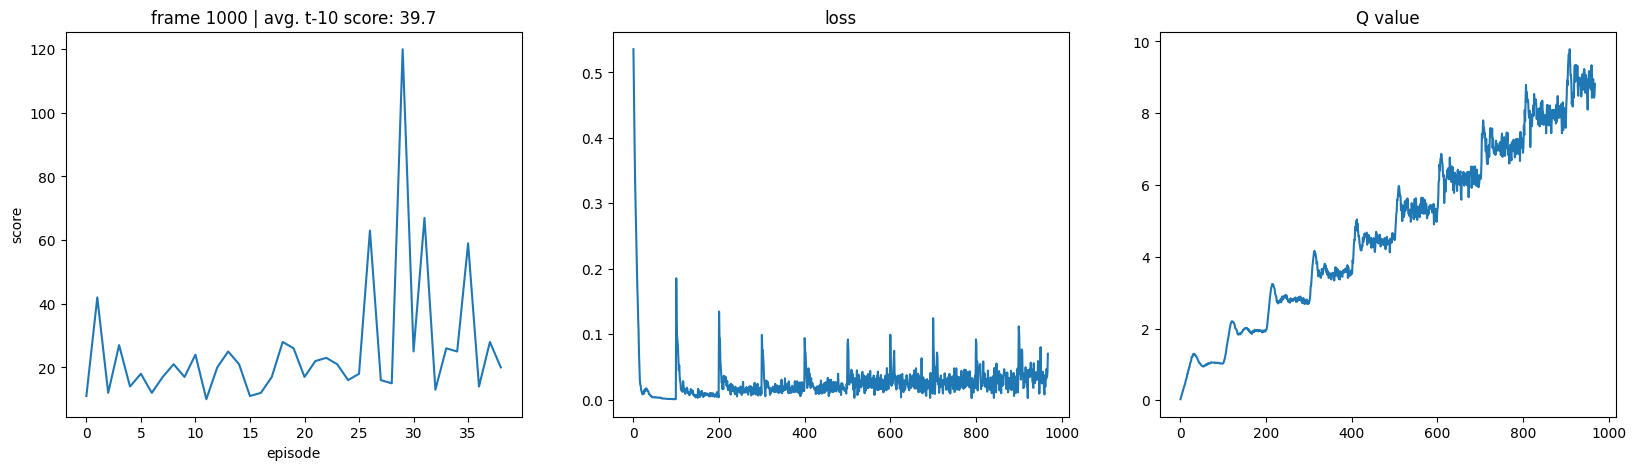

doing 1 batch
segm 10.991236060371385
our tree lookin like 1.525745767172593

indices 0 0.0 10.991236060371385 0 0.3477841289773068
indices 49 10.991236060371385 21.98247212074277 1 16.947104125955
indices 98 21.98247212074277 32.973708181114155 2 32.10664244382041
indices 127 32.973708181114155 43.96494424148554 3 42.65804826455836
indices 139 43.96494424148554 54.956180301856925 4 48.10948760699909
indices 189 54.956180301856925 65.94741636222831 5 65.04942212001563
indices 204 65.94741636222831 76.93865242259969 6 70.76495392665771
indices 224 76.93865242259969 87.92988848297108 7 80.81380401068617
indices 273 87.92988848297108 98.92112454334247 8 98.13694901321279
indices 291 98.92112454334247 109.91236060371385 9 105.85265074654806
indices 320 109.91236060371385 120.90359666408523 10 115.56845734583051
indices 369 120.90359666408523 131.89483272445662 11 131.73072808944252
indices 387 131.89483272445662 142.886068784828 12 137.39349545741396
indices 425 142.886068784828 153.877304

In [45]:
agent.train(seed, num_frames)

## Testing + recording

In [ ]:
video_folder = 'videos'
env_w_video = gym.make(env_id, render_mode="rgb_array")
# NOTE: epsilon is disabled while testing
agent = DQNAgent(env_w_video, seed, memory_size, batch_size, target_update, epsilon_decay)
saved_sd = torch.load(f'saved-states/{NB_ID}.s{seed}.pt') 
agent.load_state(saved_sd)
agent.test(video_folder)